# Neural networks for curve fitting

In [19]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [126]:
# Define the function
f = lambda x: (1 - x) * np.sin(2 * x) + (1 - x) ** 2 * np.sin(10 * x)
x = np.linspace(0, 1, 101)

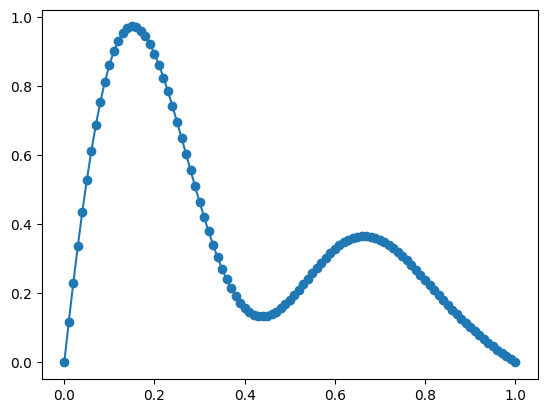

In [127]:
plt.plot(x, f(x), "o-")
plt.show()

## Build the Neural Network

In [ ]:
results = {}  # Global results dictionary
steps = [2, 5, 10, 20]
n_units = [8, 16, 32, 64]
n_layers = [2, 4, 6]

for step in steps:
    x_low = np.expand_dims(x[::step], axis=1)
    x_high = np.expand_dims(x, axis=1)
    y_low = f(x_low)
    y_high = f(x_high)

    step_results = {}  # Temporary dictionary for current step results

    for n_unit in n_units:
        for n_layer in n_layers:
            inp = x_tensor = tf.keras.layers.Input(shape=(1,))
            for _ in range(n_layer):
                x_tensor = tf.keras.layers.Dense(n_unit, activation="relu")(x_tensor)

            out = tf.keras.layers.Dense(1, activation="linear")(x_tensor)

            model = tf.keras.Model(inp, out)

            model.compile(optimizer="adam", loss="mse", metrics=["mse"])

            history = model.fit(
                x_low, y_low, batch_size=1, epochs=200, validation_split=0.2, verbose=0
            )

            # Get the final validation loss and accuracy
            final_val_loss = history.history["val_loss"][-1]
            final_val_acc = history.history["acc"][-1]

            # Store the results for this step
            step_results[(n_layer, n_unit)] = {
                "val_loss": final_val_loss,
                "val_acc": final_val_acc,
            }

    # Identify the best model for the current step
    best_config_step = min(
        step_results, key=lambda x: step_results[x]["val_loss"]
    )  # Based on validation loss
    best_val_loss_step = step_results[best_config_step]["val_loss"]
    best_val_acc_step = step_results[best_config_step]["val_acc"]

    print(f"Best Model for step {step}:")
    print(f"Layers: {best_config_step[0]}, Units: {best_config_step[1]}")
    print(
        f"Validation Loss: {best_val_loss_step:.4f}, Validation Accuracy: {best_val_acc_step:.4f}"
    )

    # Merge step results into the global results dictionary
    for key, value in step_results.items():
        results[(step, *key)] = value

# Identify the best model across all steps
# best_config_overall = min(results, key=lambda x: results[x]["val_loss"])
best_config_overall = max(results, key=lambda x: results[x]["val_acc"])
best_val_loss_overall = results[best_config_overall]["val_loss"]
best_val_acc_overall = results[best_config_overall]["val_acc"]

print("\nBest Model Overall:")
print(
    f"Step: {best_config_overall[0]}, Layers: {best_config_overall[1]}, Units: {best_config_overall[2]}"
)
print(
    f"Validation Loss: {best_val_loss_overall:.4f}, Validation Accuracy: {best_val_acc_overall:.4f}"
)

Best Model for step 2:
Layers: 6, Units: 64
Validation Loss: 0.0166, Validation Accuracy: 0.0250
Best Model for step 5:
Layers: 4, Units: 8
Validation Loss: 0.0024, Validation Accuracy: 0.0625
Best Model for step 10:
Layers: 2, Units: 8
Validation Loss: 0.0026, Validation Accuracy: 0.1250
Best Model for step 20:
Layers: 4, Units: 32
Validation Loss: 0.0066, Validation Accuracy: 0.2500

Best Model Overall:
Step: 20, Layers: 2, Units: 8
Validation Loss: 0.0542, Validation Accuracy: 0.2500


### Verify outputs

In [140]:
# Define the function
f = lambda x: (1 - x) * np.sin(2 * x) + (1 - x) ** 2 * np.sin(10 * x)
x = np.linspace(0, 1, 101)

coursening = 20

x_low = np.expand_dims(x[::coursening], axis=1)
x_high = np.expand_dims(x, axis=1)
y_low = f(x_low)
y_high = f(x_high)

# Define the parameters you want to test
n_units = 8
n_layers = 2


inp = x = tf.keras.layers.Input(shape=(1,))

for i in range(n_layers):
    x = tf.keras.layers.Dense(n_units, activation="relu")(x)
    i += 1

out = tf.keras.layers.Dense(1, activation="linear")(x)
model = tf.keras.Model(inp, out)

# Print a summary to verify the architecture (optional)
print(f"Model with {n_layers} layers and {n_units} units per layer:")
model.summary()
print("\n")

model.compile(optimizer="adam", loss="mse", metrics="acc")

history = model.fit(x_low, y_low, batch_size=1, epochs=150, validation_split=0.2)

y_pred = model.predict(x_high)
model.evaluate(y_high, y_pred)

Model with 2 layers and 8 units per layer:
Model: "model_241"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_245 (InputLayer)      [(None, 1)]               0         
                                                                 
 dense_1194 (Dense)          (None, 8)                 16        
                                                                 
 dense_1195 (Dense)          (None, 8)                 72        
                                                                 
 dense_1196 (Dense)          (None, 1)                 9         
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/150
4/4 [==============================] - 0s 21ms/step - loss: 0.2143 - mse: 0.2143 - val_loss: 0.0

## Normalizing inputs

In [68]:
# Define the function
f = lambda x: (1 - x) * np.sin(2 * x) + (1 - x) ** 2 * np.sin(10 * x)
f_vectorized = np.vectorize(f)

x = np.linspace(0, 1, 101)
coursening = 2
step = coursening

x_low = np.expand_dims(x[::step], axis=1)  # Downsample
x_high = np.expand_dims(x, axis=1)  # Full resolution
y_low = f_vectorized(x_low)
y_high = f_vectorized(x_high)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_low = scaler.fit_transform(x_low)
x_high = scaler.transform(x_high)

# Define the parameters you want to test
n_units = 32
n_layers = 2

# Build the model
inp = tf.keras.layers.Input(shape=(1,))
x = inp
for _ in range(n_layers):
    x = tf.keras.layers.Dense(n_units, activation="tanh")(x)
out = tf.keras.layers.Dense(1, activation="linear")(x)
model = tf.keras.Model(inp, out)

# Print a summary to verify the architecture (optional)
print(f"Model with {n_layers} layers and {n_units} units per layer:")
model.summary()
print("\n")

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.9
# )

# Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss="mse", metrics=["mse"])
model.compile(optimizer="adam", loss="mse", metrics=["mse"])


# Train the model
history = model.fit(x_low, y_low, batch_size=1, epochs=1000, validation_split=0.2)

# Predict and evaluate
y_pred = model.predict(x_high)
mse = tf.keras.losses.MeanSquaredError()
error = mse(y_high, y_pred).numpy()

print(f"\nMean Squared Error on the high-resolution data: {error}")

Model with 2 layers and 32 units per layer:
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_150 (Dense)           (None, 32)                64        
                                                                 
 dense_151 (Dense)           (None, 32)                1056      
                                                                 
 dense_152 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.1575 - mse: 0.1575 - val_loss: 0.208

In [69]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,mse,val_loss,val_mse
995,0.000823,0.000823,0.019169,0.019169
996,0.000354,0.000354,0.021670,0.021670
997,0.000243,0.000243,0.019222,0.019222
998,0.000274,0.000274,0.019839,0.019839
999,0.000323,0.000323,0.024714,0.024714


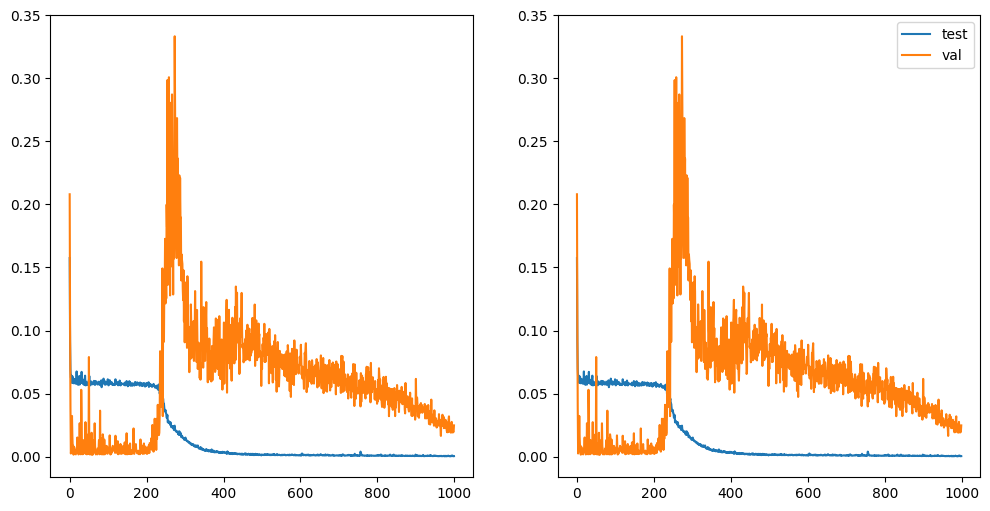

In [70]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist.mse, label="test")
plt.plot(hist.val_mse, label="val")

plt.subplot(1, 2, 2)
plt.plot(hist.loss, label="test")
plt.plot(hist.val_loss, label="val")

plt.legend()
plt.show()

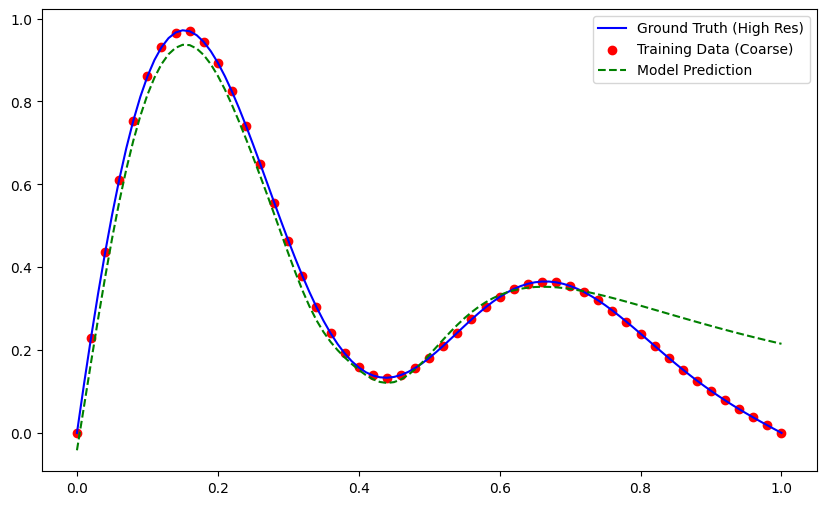

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(x_high, y_high, label="Ground Truth (High Res)", color="blue")
plt.scatter(x_low, y_low, label="Training Data (Coarse)", color="red")
plt.plot(x_high, y_pred, label="Model Prediction", color="green", linestyle="dashed")
plt.legend()
plt.show()

# This is from ChatGPT

4/4 [==============================] - 0s 671us/step


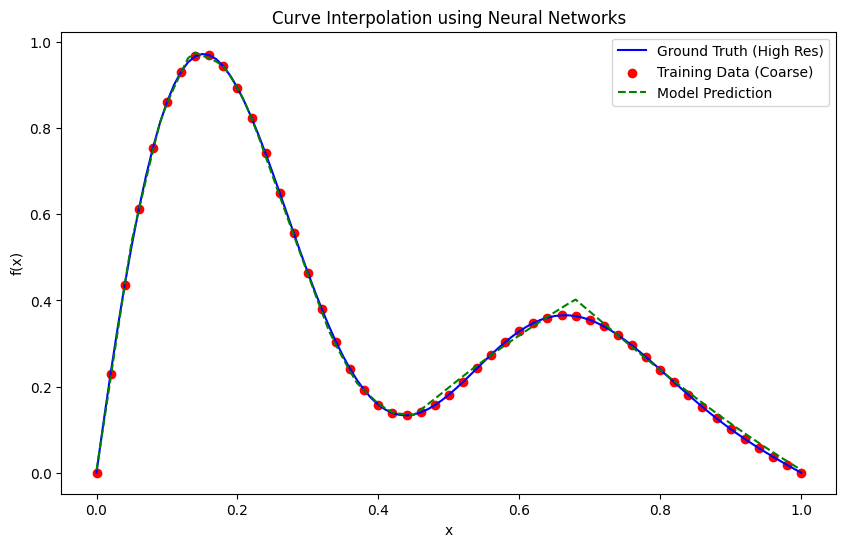

In [77]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the function
f = lambda x: (1 - x) * np.sin(2 * x) + (1 - x) ** 2 * np.sin(10 * x)

# Data generation
x = np.linspace(0, 1, 101)
coursening = 2
x_low = np.expand_dims(x[::coursening], axis=1)  # Coarse input
x_high = np.expand_dims(x, axis=1)  # Fine input
y_low = f(x_low)  # Coarse output
y_high = f(x_high)  # Fine output

# Normalize data 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_low_normalized = scaler.fit_transform(x_low)
x_high = scaler.transform(x_high)

# model = tf.keras.Sequential(
#     [
#         tf.keras.layers.Dense(32, activation="relu", input_shape=(1,)),  # Input layer
#         tf.keras.layers.Dense(64, activation="relu"),  # Hidden layer
#         tf.keras.layers.Dense(1),  # Output layer
#     ]
# )

# Build the model
inp = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(32, activation="relu")(inp)
x = tf.keras.layers.Dense(32, activation="tanh")(x)
x = tf.keras.layers.Dense(32, activation="tanh")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
out = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inp, out)


# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(
    x_low_normalized, y_low, batch_size=1, epochs=500, verbose=0
)

# Predict values for the high-resolution data
y_pred = model.predict(x_high)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_high, y_high, label="Ground Truth (High Res)", color="blue")
plt.scatter(x_low, y_low, label="Training Data (Coarse)", color="red")
plt.plot(x_high, y_pred, label="Model Prediction", color="green", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Curve Interpolation using Neural Networks")
plt.show()

# This is from DeepSeek

4/4 [==============================] - 0s 744us/step


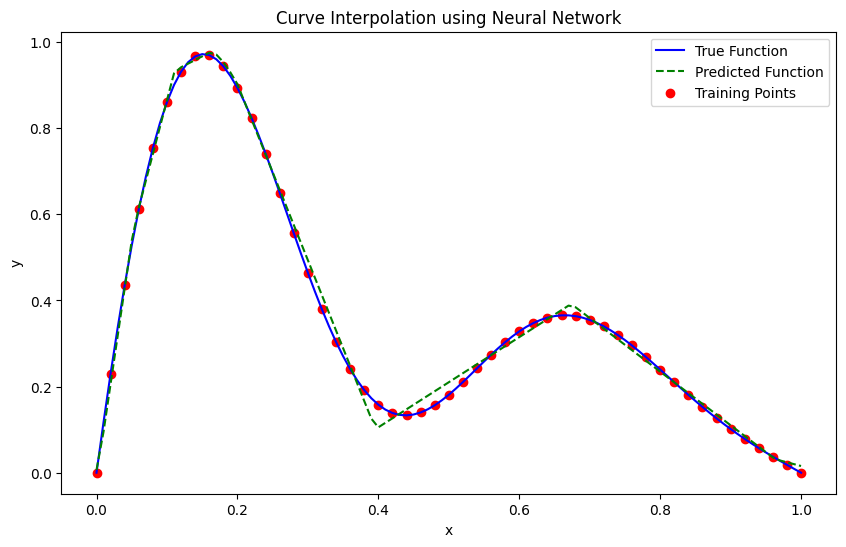

In [84]:
# Define the function
f = lambda x: (1 - x) * np.sin(2 * x) + (1 - x) ** 2 * np.sin(10 * x)
x = np.linspace(0, 1, 101)

coursening = 2

x_low = np.expand_dims(x[::coursening], axis=1)
x_high = np.expand_dims(x, axis=1)
y_low = f(x_low)
y_high = f(x_high)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_low = scaler.fit_transform(x_low)
x_high = scaler.transform(x_high)

# Define the model
inp = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(10, activation="relu")(inp)
x = tf.keras.layers.Dense(10, activation="relu")(x)
out = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inp, out)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(x_low, y_low, batch_size=1, epochs=1000, verbose=0)

# Predict y_high using the trained model
y_pred = model.predict(x_high)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_high, y_high, label='True Function', color='blue')
plt.plot(x_high, y_pred, label='Predicted Function', color='green', linestyle='--')
plt.scatter(x_low, y_low, label='Training Points', color='red')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Interpolation using Neural Network')
plt.show()

In [85]:
y_low

array([[0.        ],
       [0.22999157],
       [0.43560605],
       [0.61144756],
       [0.75374295],
       [0.8603939 ],
       [0.93094938],
       [0.96650448],
       [0.96953505],
       [0.94368002],
       [0.89348503],
       [0.82412199],
       [0.74109971],
       [0.64997985],
       [0.55611192],
       [0.46439854],
       [0.3791007 ],
       [0.30368969],
       [0.24074982],
       [0.19193312],
       [0.15796476],
       [0.13869492],
       [0.13319136],
       [0.13986458],
       [0.15661671],
       [0.18100442],
       [0.21040608],
       [0.24218363],
       [0.27383097],
       [0.30310148],
       [0.32810915],
       [0.34739981],
       [0.35999049],
       [0.36537732],
       [0.36351388],
       [0.35476371],
       [0.3398319 ],
       [0.31968169],
       [0.29544261],
       [0.26831668],
       [0.23948905],
       [0.21004882],
       [0.18092464],
       [0.15283875],
       [0.12628133],
       [0.10150595],
       [0.07854514],
       [0.057